In [1]:
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

/Users/blairthurman/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Useful Functions

In [2]:
def model_fit(model, train, target, timed=True, feature_importance=False):
    '''
    This function is for checking performance of a single model. 
    
    Optional plot of feature importance for ensemble methods.
    '''
    # Fit
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    model.fit(train, target)
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
    
    # CV
    cv_score = cross_validation.cross_val_score(model, train, target, cv=5, scoring='roc_auc')
    print(f'CV Score : Mean - {np.mean(cv_score):.3f} | Std - {np.std(cv_score):.3f} | Min - {np.min(cv_score):.3f} | Max - {np.max(cv_score):.3f}')
    if timed:
        passed = time() - start
        print(f'Seconds to CV: {passed:.2f}')
    
    # Plots feature importance, for ensemble models only
    if feature_importance:
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [3]:
def grid_searcher(model, train, target, parameters={}, cv=4, timed=True):
    '''
    Makes a printout of the AUC score for gridsearched models.
    '''
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=4,
        cv=cv)
    gsearcher.fit(train, target)
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
    print('Grid Scores: \n')
    pp.pprint(gsearcher.cv_results_)
    print(f'Best Model Parameters: {gsearcher.best_params_}')
    print(f'Best Model Score: {gsearcher.best_score_:.4f}')

In [4]:
def cv_plotter(x, y, title, feature_label):
    '''
    Makes a simple scatter plot
    '''
    plt.scatter(x=x, y=y)
    plt.title(f'{title} AUC over {feature_label}')
    plt.xlabel(feature_label)
    plt.ylabel('AUC Score')

In [5]:
def sampler(train, test, size):
    '''
    Just a hack of a function to quickly sample out data. 
    
    Size: Float, 0.0 - 1.0
        Fraction of data you want returned
    '''
    test_size = 1 - size
    results = train_test_split(train, test, test_size=test_size, random_state=42)
    return results[0], results[2]

# Load

In [6]:
df = pd.read_csv('data/application_train_pca.csv')
train = df[df.columns[2:]]
target = df['target']
df.head()

,sk_id_curr,target,0,1,2,3,4,5,6,7,...,28,29,30,31,32,33,34,35,36,37
0,100002,1,0.311091,-1.332634,-0.399883,-2.000222,0.390812,0.672156,-0.191782,1.242912,...,0.094919,0.108869,-0.097447,0.207195,1.110724,-0.885310,0.271509,0.201748,0.078745,-1.013988
1,100003,0,1.003885,2.295670,-0.859131,-1.410614,0.350578,-0.441695,1.138504,-0.655109,...,0.215964,0.051572,0.488226,-0.041404,-0.785569,1.252293,1.370241,-0.178892,-0.732245,0.653229
2,100004,0,-0.356299,-2.745839,0.603927,-0.145268,2.845680,-0.206305,-1.628813,-0.740097,...,-0.140227,0.215135,-0.424872,0.097197,0.123388,0.143478,0.539556,0.226337,-0.640607,-1.492682
3,100006,0,-0.452229,-0.706371,-1.026894,-1.142946,-0.490824,-0.542183,-0.185623,0.939177,...,0.015248,-0.032642,-0.234938,-0.217559,0.080454,-0.554469,-0.494474,0.734851,-0.315487,0.781315
4,100007,0,0.396743,-0.732436,2.179659,-0.024886,1.154158,2.721180,-2.287210,0.657978,...,0.434943,0.120781,-0.307910,-0.718415,-0.035805,-1.283724,0.026249,0.483156,2.127985,-0.200012


# Modeling

## XGBoost

---
### Benchmark

Seconds to start: 0.00
Seconds to fit: 115.55
CV Score : Mean - 0.688 | Std - 0.002 | Min - 0.685 | Max - 0.690
Seconds to CV: 558.01


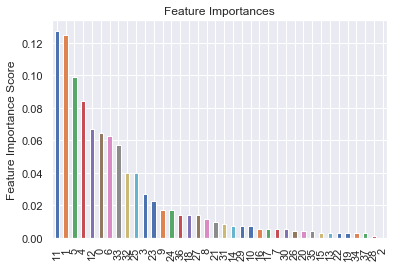

In [7]:
model = XGBClassifier()

model_fit(model, train, target, feature_importance=True)

---
### Data

In [13]:
train_sample, test_sample = sampler(train, target, 1/5)

---
### n_estimators

In [10]:
parameters = {
    'n_estimators': range(20, 101, 10)
}

model = XGBClassifier(
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=1.0,
    colsample_bytree=1.0,
    scale_pos_weight=0.5,
    learning_rate=0.1,
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 243.43
Grid Scores: 

{'mean_fit_time': array([ 8.67627144, 11.79463679, 15.56078768, 19.40552145, 23.25121439,
       27.1758576 , 31.42106175, 35.05236757, 38.96454382]),
 'mean_score_time': array([0.04796177, 0.05684268, 0.05866659, 0.08223128, 0.09467876,
       0.10515928, 0.11150926, 0.11441666, 0.11384946]),
 'mean_test_score': array([0.65411723, 0.66617186, 0.6748186 , 0.6788663 , 0.68029374,
       0.68112375, 0.68141858, 0.68160528, 0.68202856]),
 'mean_train_score': array([0.71131868, 0.73588765, 0.75556637, 0.77107572, 0.78415205,
       0.79462101, 0.80321201, 0.81231649, 0.82043955]),
 'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80, 90, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object),
 'params': [{'n_estimators': 20},
            {'n_estimators': 30},
            {'n_estimators': 40},
            {'n_estim

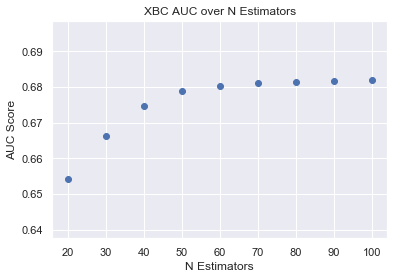

In [11]:
x = range(20, 101, 10)
y = [0.65411723, 0.66617186, 0.6748186 , 0.6788663 , 0.68029374,
       0.68112375, 0.68141858, 0.68160528, 0.68202856]
cv_plotter(x, y, 'XBC', 'N Estimators')

In [24]:
parameters = {
    'n_estimators': range(60, 141, 20)
}

model = XGBClassifier(
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=1.0,
    colsample_bytree=1.0,
    scale_pos_weight=0.5,
    learning_rate=0.1,
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 255.34
Grid Scores: 

{'mean_fit_time': array([32.59346426, 34.52305663, 42.13688123, 51.02830827, 58.46833873]),
 'mean_score_time': array([0.115367  , 0.11142927, 0.14764076, 0.15629524, 0.17508006]),
 'mean_test_score': array([0.68029374, 0.68141858, 0.68202856, 0.68143364, 0.68121974]),
 'mean_train_score': array([0.78415205, 0.80321201, 0.82043955, 0.834667  , 0.84835808]),
 'param_n_estimators': masked_array(data=[60, 80, 100, 120, 140],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'n_estimators': 60},
            {'n_estimators': 80},
            {'n_estimators': 100},
            {'n_estimators': 120},
            {'n_estimators': 140}],
 'rank_test_score': array([5, 3, 1, 2, 4], dtype=int32),
 'split0_test_score': array([0.67791407, 0.67884425, 0.67896059, 0.67754748, 0.67617684]),
 'split0_train_score': array([0.78859069, 0.80825091, 0.826348  , 0.84137521, 0.855318

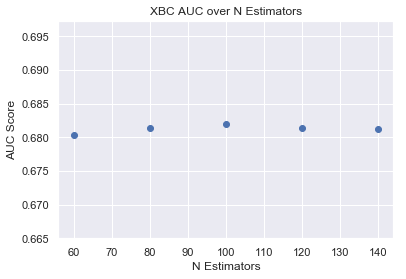

In [25]:
x = range(60, 141, 20)
y = [0.68029374, 0.68141858, 0.68202856, 0.68143364, 0.68121974]
cv_plotter(x, y, 'XBC', 'N Estimators')

100 trees here

---
### max_depth

In [26]:
parameters = {
    'max_depth': range(3, 10)
}

model = XGBClassifier(
    n_estimators=100,
    min_child_weight=1,
    gamma=0,
    subsample=1.0,
    colsample_bytree=1.0,
    scale_pos_weight=0.5,
    learning_rate=0.1,
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 441.78
Grid Scores: 

{'mean_fit_time': array([28.10474026, 42.80416191, 44.58547634, 67.04867703, 69.69356048,
       79.32903433, 84.95207822]),
 'mean_score_time': array([0.14807397, 0.13850629, 0.13802505, 0.25668144, 0.25408196,
       0.21696717, 0.25998431]),
 'mean_test_score': array([0.68427622, 0.68369683, 0.68202856, 0.6787101 , 0.67575431,
       0.67408312, 0.66823865]),
 'mean_train_score': array([0.7386693 , 0.77581269, 0.82043955, 0.86635399, 0.91362228,
       0.94877485, 0.97486739]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max_depth': 8},
            {'max_depth': 9}],
 'rank_test_score': array([1, 2, 3, 4, 5, 6, 7], dtype=int32),

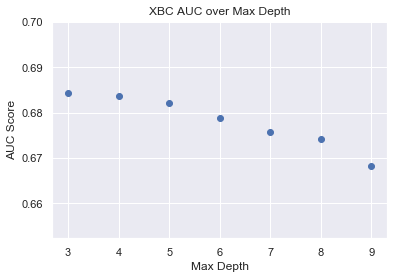

In [27]:
x = range(3, 10)
y = [0.68427622, 0.68369683, 0.68202856, 0.6787101 , 0.67575431,
       0.67408312, 0.66823865]
cv_plotter(x, y, 'XBC', 'Max Depth')

3 it is this time

---
### min_child_weight

In [28]:
parameters = {
    'min_child_weight': range(1, 8)
}

model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    gamma=0,
    subsample=1.0,
    colsample_bytree=1.0,
    scale_pos_weight=0.5,
    learning_rate=0.1,
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 179.09
Grid Scores: 

{'mean_fit_time': array([25.93529135, 22.38775057, 22.57790983, 22.12250465, 22.14968276,
       22.09643066, 22.26990128]),
 'mean_score_time': array([0.09979212, 0.0923593 , 0.09661418, 0.08533216, 0.08252865,
       0.08198541, 0.07326216]),
 'mean_test_score': array([0.68427622, 0.6835755 , 0.68417814, 0.68361139, 0.68417834,
       0.68427515, 0.68400389]),
 'mean_train_score': array([0.7386693 , 0.73781746, 0.73702168, 0.7364176 , 0.73664371,
       0.7355454 , 0.73557404]),
 'param_min_child_weight': masked_array(data=[1, 2, 3, 4, 5, 6, 7],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_child_weight': 1},
            {'min_child_weight': 2},
            {'min_child_weight': 3},
            {'min_child_weight': 4},
            {'min_child_weight': 5},
            {'min_child_weight': 6},
            {'min_child_weight': 7}],
 'rank

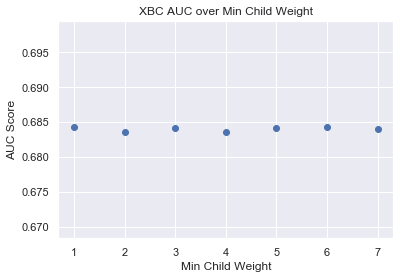

In [29]:
x = range(1, 8)
y = [0.68427622, 0.6835755 , 0.68417814, 0.68361139, 0.68417834,
       0.68427515, 0.68400389]
cv_plotter(x, y, 'XBC', 'Min Child Weight')

Neat, just sticking with 1 again, not much fluctuation here./


---
### gamma

In [30]:
parameters = {
    'gamma': np.arange(0.0, 0.6, 0.1)
}

model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=1.0,
    scale_pos_weight=0.5,
    learning_rate=0.1,
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 172.17
Grid Scores: 

{'mean_fit_time': array([24.00964379, 25.28169459, 25.7905764 , 24.12879723, 28.05706477,
       24.65962386]),
 'mean_score_time': array([0.09482479, 0.14940524, 0.08990932, 0.09581167, 0.09298736,
       0.08814758]),
 'mean_test_score': array([0.68427622, 0.68454572, 0.68316335, 0.68379308, 0.68434285,
       0.68373129]),
 'mean_train_score': array([0.7386693 , 0.73907477, 0.73877513, 0.73935609, 0.7389076 ,
       0.7387767 ]),
 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'gamma': 0.0},
            {'gamma': 0.1},
            {'gamma': 0.2},
            {'gamma': 0.30000000000000004},
            {'gamma': 0.4},
            {'gamma': 0.5}],
 'rank_test_score': array([3, 1, 6, 4, 2, 5], dtype=int32),
 'split0_test_score': array([0.68238804, 0.68165738, 0.68165738

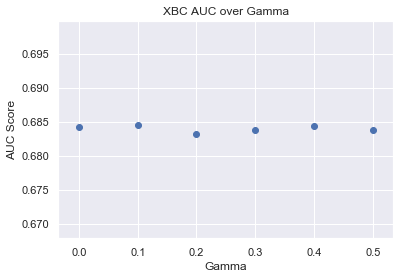

In [31]:
x = x = np.arange(0.0, 0.6, 0.1)
y = [0.68427622, 0.68454572, 0.68316335, 0.68379308, 0.68434285,
       0.68373129]
cv_plotter(x, y, 'XBC', 'Gamma')

Setting gamma to 0.1

---
### subsample

In [15]:
parameters = {
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    min_child_weight=1,
    gamma=0.1,
    colsample_bytree=1.0,
    scale_pos_weight=0.5,
    learning_rate=0.1,
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 159.95
Grid Scores: 

{'mean_fit_time': array([19.92357302, 22.93375194, 24.33000213, 23.01577896, 25.4172219 ,
       24.46254206]),
 'mean_score_time': array([0.12258619, 0.08877832, 0.09605783, 0.11735702, 0.09134686,
       0.08752751]),
 'mean_test_score': array([0.68355446, 0.68431964, 0.6846233 , 0.68411999, 0.6859445 ,
       0.68454572]),
 'mean_train_score': array([0.73214935, 0.7342149 , 0.73600782, 0.73682033, 0.73783442,
       0.73907477]),
 'param_subsample': masked_array(data=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'subsample': 0.5},
            {'subsample': 0.6},
            {'subsample': 0.7},
            {'subsample': 0.8},
            {'subsample': 0.9},
            {'subsample': 1.0}],
 'rank_test_score': array([6, 4, 2, 5, 1, 3], dtype=int32),
 'split0_test_score': array([0.68366771, 0.6835947 , 0.68432684, 0.

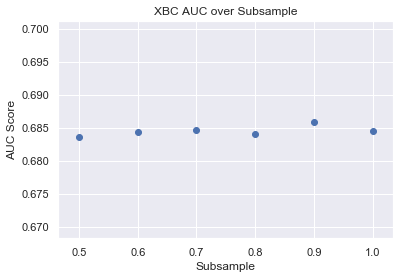

In [19]:
x = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y = [0.68355446, 0.68431964, 0.6846233 , 0.68411999, 0.6859445 ,
       0.68454572]
cv_plotter(x, y, 'XBC', 'Subsample')

---
### colsample_bytree

In [20]:
parameters = {
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    scale_pos_weight=0.5,
    learning_rate=0.1,
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 136.12
Grid Scores: 

{'mean_fit_time': array([13.68739229, 14.7819767 , 16.12863797, 17.88667554, 21.26081622,
       30.79927754]),
 'mean_score_time': array([0.12613493, 0.09250033, 0.10701203, 0.09230596, 0.14705932,
       0.09006518]),
 'mean_test_score': array([0.68428031, 0.68515731, 0.68555163, 0.68476768, 0.68492221,
       0.6859445 ]),
 'mean_train_score': array([0.73487209, 0.73554591, 0.73640519, 0.73707006, 0.73698988,
       0.73783442]),
 'param_colsample_bytree': masked_array(data=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'colsample_bytree': 0.5},
            {'colsample_bytree': 0.6},
            {'colsample_bytree': 0.7},
            {'colsample_bytree': 0.8},
            {'colsample_bytree': 0.9},
            {'colsample_bytree': 1.0}],
 'rank_test_score': array([6, 3, 2, 5, 4, 1], dtype=int32),
 'split0_test_scor

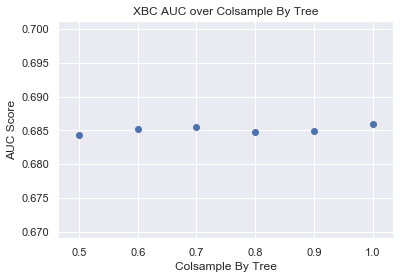

In [22]:
x = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y = [0.68428031, 0.68515731, 0.68555163, 0.68476768, 0.68492221,
       0.6859445]
cv_plotter(x, y, 'XBC', 'Colsample By Tree')

Looks like the default of 1.0 is the right parameter here

---
### scale_pos_weight

In [25]:
parameters = {
    'scale_pos_weight': np.arange(0.0, 1.1, 0.2)
}

model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=1.0,
    learning_rate=0.1,
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 166.16
Grid Scores: 

{'mean_fit_time': array([11.67996299, 26.06900322, 28.79568923, 22.98619199, 30.41998023,
       26.33239233]),
 'mean_score_time': array([0.04177415, 0.0824275 , 0.09983158, 0.09352326, 0.107979  ,
       0.0831098 ]),
 'mean_test_score': array([0.5       , 0.68429407, 0.68432293, 0.68553968, 0.68501612,
       0.68510961]),
 'mean_train_score': array([0.5       , 0.73105689, 0.73682098, 0.73881381, 0.74149348,
       0.7431812 ]),
 'param_scale_pos_weight': masked_array(data=[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'scale_pos_weight': 0.0},
            {'scale_pos_weight': 0.2},
            {'scale_pos_weight': 0.4},
            {'scale_pos_weight': 0.6000000000000001},
            {'scale_pos_weight': 0.8},
            {'scale_pos_weight': 1.0}],
 'rank_test_score': array([6, 5, 4, 1, 3, 2], dt

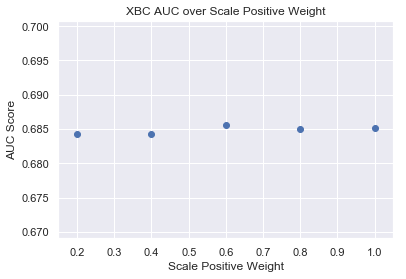

In [29]:
x = np.arange(0.2, 1.1, 0.2)
y = [0.68429407, 0.68432293, 0.68553968, 0.68501612,
       0.68510961]
cv_plotter(x, y, 'XBC', 'Scale Positive Weight')

Going with 0.6

---
### learning_rate

---
* n_estimators: 100
* learning_rate: 0.1

Seconds to start: 0.00
Seconds to fit: 17.36
CV Score : Mean - 0.686 | Std - 0.007 | Min - 0.677 | Max - 0.695
Seconds to CV: 83.98


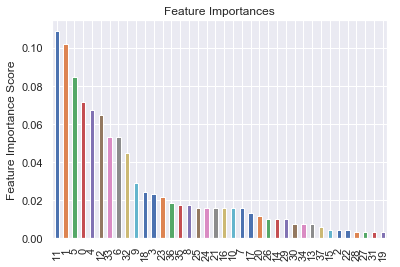

In [30]:
model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=1.0,
    scale_pos_weight=0.6,
    learning_rate=0.1,
)


model_fit(model, train_sample, test_sample, feature_importance=True)

---
* n_estimators: 200
* learning_rate: 0.05

Seconds to start: 0.00
Seconds to fit: 33.36
CV Score : Mean - 0.686 | Std - 0.006 | Min - 0.678 | Max - 0.694
Seconds to CV: 163.47


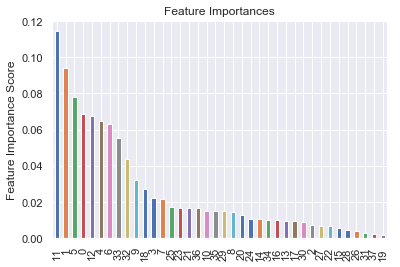

In [31]:
model = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=1.0,
    scale_pos_weight=0.6,
    learning_rate=0.05,
)


model_fit(model, train_sample, test_sample, feature_importance=True)

---
* n_estimators: 333
* learning_rate: 0.03

Seconds to start: 0.00
Seconds to fit: 58.74
CV Score : Mean - 0.686 | Std - 0.006 | Min - 0.679 | Max - 0.695
Seconds to CV: 270.56


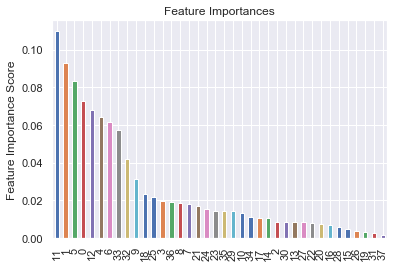

In [32]:
model = XGBClassifier(
    n_estimators=333,
    max_depth=3,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=1.0,
    scale_pos_weight=0.6,
    learning_rate=0.03,
)

model_fit(model, train_sample, test_sample, feature_importance=True)

---
* n_estimators: 666
* learning_rate: 0.02

Seconds to start: 0.00
Seconds to fit: 107.21
CV Score : Mean - 0.688 | Std - 0.006 | Min - 0.679 | Max - 0.696
Seconds to CV: 536.39


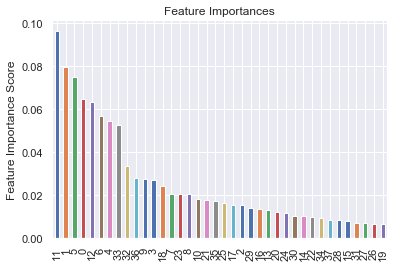

In [33]:
model = XGBClassifier(
    n_estimators=666,
    max_depth=3,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=1.0,
    scale_pos_weight=0.6,
    learning_rate=0.02
)

model_fit(model, train_sample, test_sample, feature_importance=True)

---
* n_estimators: 1333
* learning_rate: 0.01

In [ ]:
# Haven't run this yet, would likely take 15+ mins to run locally

# model = XGBClassifier(
#     n_estimators=1333,
#     max_depth=3,
#     min_child_weight=1,
#     gamma=0.1,
#     subsample=0.9,
#     colsample_bytree=1.0,
#     scale_pos_weight=0.6,
#     learning_rate=0.01
# )


# model_fit(model, train_sample, test_sample, feature_importance=True)